In [1]:
library("Matrix")
library(Seurat)
library(DT)
library(dplyr)
library(here)
library(ggplot2)
library(SingleCellExperiment)
library(scater)
library(mclust)
library(kableExtra)
library(cowplot)
library(tidyverse)
library(reshape)
library(harmony)
library(SingleR)
library(topGO)
library(annotate)
library("org.Mm.eg.db")
library(biomaRt)
library(ReactomePA)
library(seq2pathway)
library(scCustomize)
library(future)
library(ggnewscale)
library(furrr)
library(readxl)
library(STACAS)
library(clusterProfiler)

rank_score_func <- function(df){

df <- df %>% mutate(score = -1*log(p_val_adj+(10^-310))*avg_logFC*(pct.1/(pct.2+10^-300)))

return(df)
}

convertHumanGeneList <- function(x){

require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")

genesV2 = getLDS(attributes = c("hgnc_symbol"), filters = "hgnc_symbol", values = x , mart = human, attributesL = c("mgi_symbol"), martL = mouse, uniqueRows=T)

humanx <- unique(genesV2[, 2])

# Print the first 6 genes found to the screen
print(head(humanx))
return(humanx)
}

library("remotes")
library("fs")

ggtheme <- function() {
  theme(
    axis.text = element_text(size = 20),
    axis.title = element_text(size = 20),
    text = element_text(size = 20, colour = "black"),
    legend.text = element_text(size = 20),
    legend.key.size =  unit(10, units = "points")
    
  )
}

mid.se <- celldex::MonacoImmuneData();

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject


Attaching package: ‘DT’


The following object is masked from ‘package:SeuratObject’:

    JS


The following object is masked from ‘package:Seurat’:

    JS



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


here() starts at /home/vercanie/PRIMUS/data/48_lab/Jupyter/231003_DiabetesV02

Loading required package: SummarizedExperiment

Loading requir

Warning message:
“replacing previous import ‘WGCNA::cor’ by ‘stats::cor’ when loading ‘seq2pathway’”
scCustomize v1.1.1
If you find the scCustomize useful please cite.
See 'samuel-marsh.github.io/scCustomize/articles/FAQ.html' for citation info.

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:AnnotationDbi’:

    select


The following object is masked from ‘package:reshape’:

    rename


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:IRanges’:

    sli

# All diabetes data - new and old

## CD8 new

In [3]:
paths  <- list.files("data/rawdata/", full.names = T)

In [4]:
paths

[1] "data/rawdata//exp08_init_with_Mixcr.rds"      
 [2] "data/rawdata//exp10_init_with_Mixcr.rds"      
 [3] "data/rawdata//exp11_W1_init_with_Mixcr.rds"   
 [4] "data/rawdata//exp11_W2_init_with_Mixcr.rds"   
 [5] "data/rawdata//exp16_CD4_A_init_with_Mixcr.rds"
 [6] "data/rawdata//exp16_CD4_B_init_with_Mixcr.rds"
 [7] "data/rawdata//exp16_CD8_A_init_with_Mixcr.rds"
 [8] "data/rawdata//exp16_CD8_B_init_with_Mixcr.rds"
 [9] "data/rawdata//exp18_1_init_with_Mixcr.rds"    
[10] "data/rawdata//exp18_2_init_with_Mixcr.rds"    
[11] "data/rawdata//exp18_3_init_with_Mixcr.rds"    
[12] "data/rawdata//exp18_4_init_with_Mixcr.rds"    
[13] "data/rawdata//exp19_1_init_with_Mixcr.rds"    
[14] "data/rawdata//exp19_2_init_with_Mixcr.rds"    
[15] "data/rawdata//exp19_3_init_with_Mixcr.rds"    
[16] "data/rawdata//exp19_4_init_with_Mixcr.rds"    
[17] "data/rawdata//exp20_1_init_with_Mixcr.rds"    
[18] "data/rawdata//exp20_2_init_with_Mixcr.rds"    
[19] "data/rawdata//exp20_3_init_with_Mixcr.rds"    
[20] "data/rawdata//exp20_4_init_with_Mixcr.rds"

In [5]:
seu_list  <- map(paths[c(1,2,3,7,8,9,11,13,15,17,19)], readRDS)

In [6]:
seu_list[[2]]$hashtags  %>% table

.
 H1 H10  H2  H3  H4  H5  H6  H7  H8  H9 
743 831 821 762 825 695 821 761 787 802 

In [7]:
exp10_cd8  <- subset(seu_list[[2]], hashtags == "H5")

In [8]:
seu_list[[2]] <- exp10_cd8

In [9]:
new_dia_cd8  <- scCustomize::Merge_Seurat_List(seu_list)

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


In [10]:
new_dia_cd8

An object of class Seurat 
15166 features across 111682 samples within 3 assays 
Active assay: RNA (15152 features, 0 variable features)
 2 other assays present: Antibodies, PTPRC

In [11]:
options(future.globals.maxSize = 10000 * 1024^2)
plan("sequential")

In [12]:
DefaultAssay(new_dia_cd8)  <- "RNA"
new_dia_cd8 <- NormalizeData(new_dia_cd8, verbose = FALSE)
new_dia_cd8 <- ScaleData(new_dia_cd8, verbose = FALSE)
new_dia_cd8 <- FindVariableFeatures(new_dia_cd8, nfeatures = 1000, verbose = FALSE)
new_dia_cd8 <- RunPCA(new_dia_cd8, npcs = 12, verbose = FALSE)
new_dia_cd8 <- RunUMAP(new_dia_cd8, reduction = "pca", dims = 1:12)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:09:10 UMAP embedding parameters a = 0.9922 b = 1.112

10:09:10 Read 111682 rows and found 12 numeric columns

10:09:10 Using Annoy for neighbor search, n_neighbors = 30

10:09:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:09:26 Writing NN index file to temp file /tmp/RtmpM7YS7v/file48bc03923cbcf

10:09:26 Searching Annoy index using 1 thread, search_k = 3000

10:10:25 Annoy recall = 100%

10:10:26 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbor

In [13]:
new_dia_cd8 <- FindNeighbors(new_dia_cd8, dims = 1:12)
new_dia_cd8 <- FindClusters(new_dia_cd8, resolution = 1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 111682
Number of edges: 2924932

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8590
Number of communities: 22
Elapsed time: 79 seconds


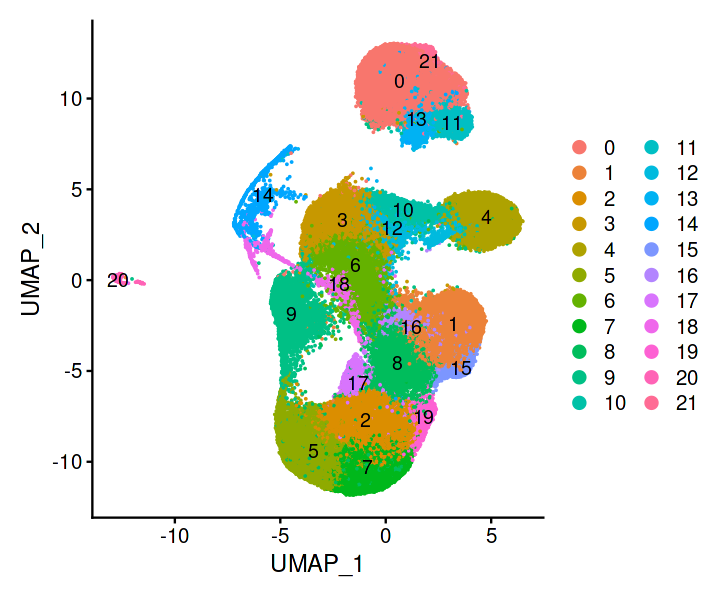

In [14]:
options(repr.plot.width = 6, repr.plot.height = 5)

DimPlot(new_dia_cd8, label = T, raster = F)

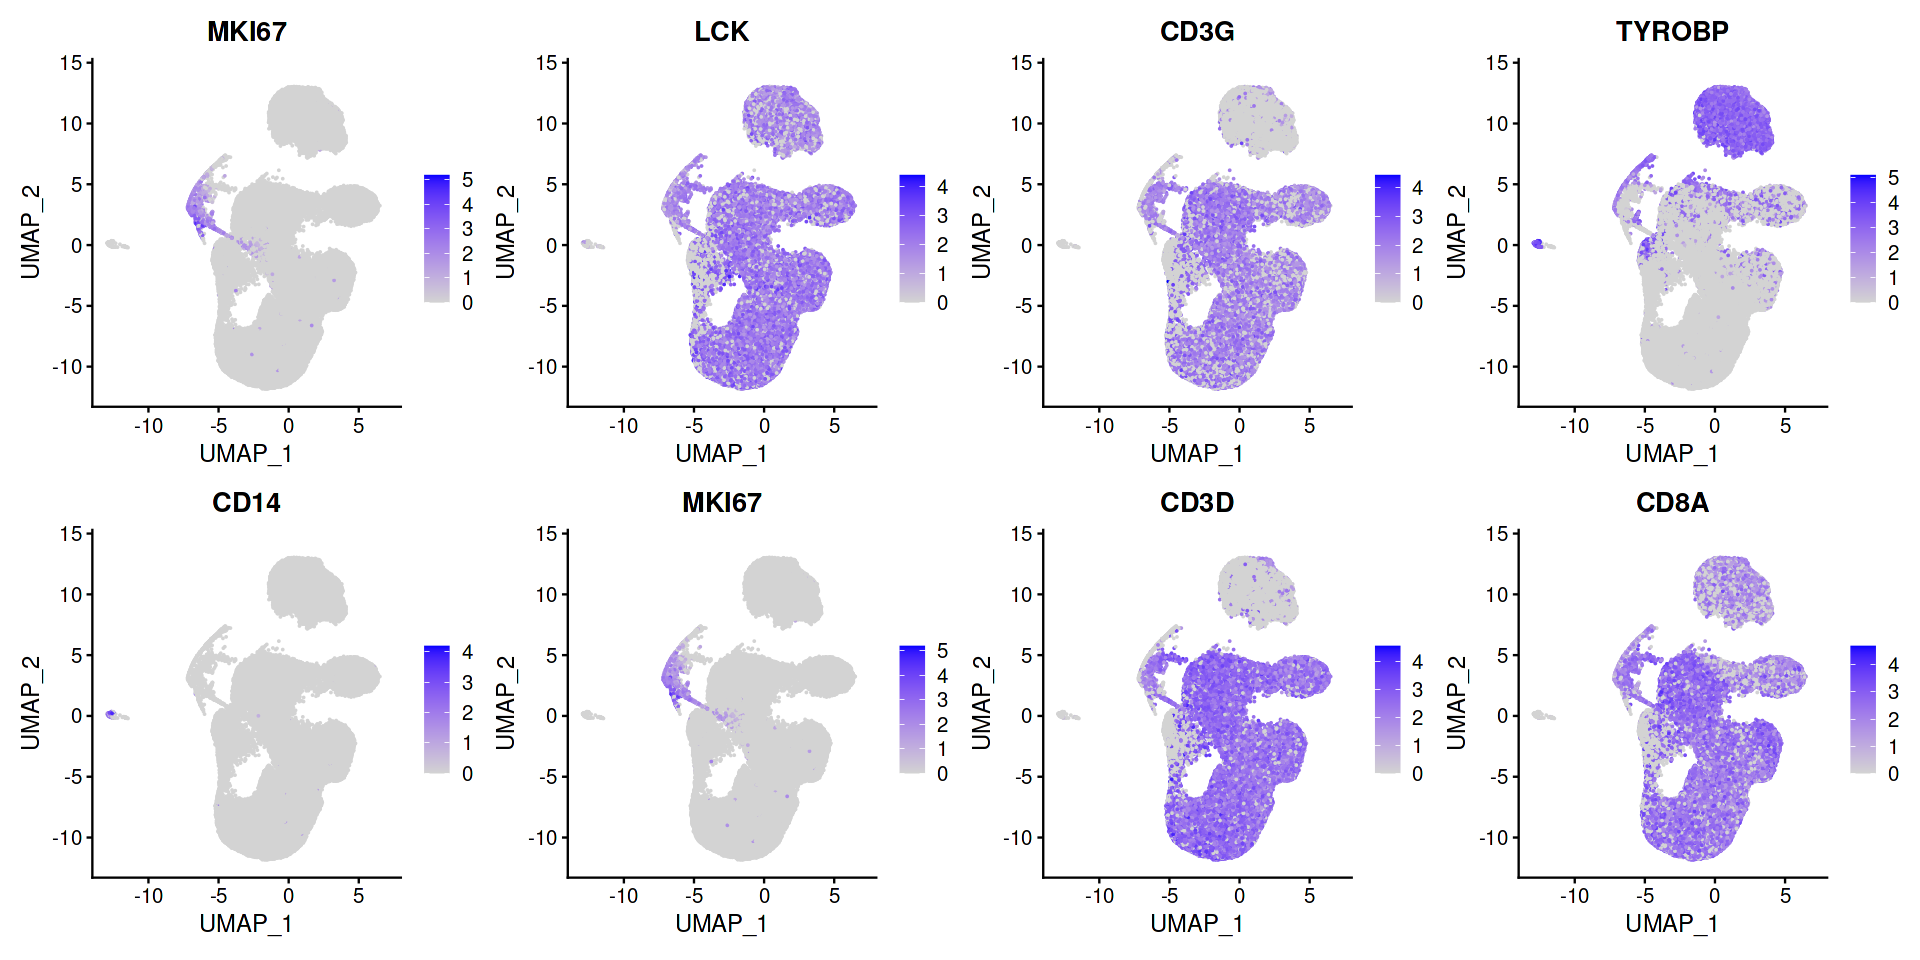

In [15]:
options(repr.plot.width = 16, repr.plot.height = 8)
FeaturePlot(new_dia_cd8, features = c("MKI67", "LCK", "CD3G", "TYROBP", "CD14", "MKI67", "CD3D", "CD8A"), ncol = 4, raster = F)

### Automated annotation of cell types

In [16]:
library(Azimuth)
mid.se <- celldex::MonacoImmuneData()
hpca.se  <- celldex::HumanPrimaryCellAtlasData()
load("data/ref_wherry_new.RData")

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Attaching shinyBS

rgeos version: 0.6-3, (SVN revision 696)
 GEOS runtime version: 3.8.0-CAPI-1.13.1 
 Please note that rgeos will be retired during October 2023,
plan transition to sf or terra functions using GEOS at your earliest convenience.
See https://r-spatial.org/r/2023/05/15/evolution4.html for details.
 Linking to sp version: 1.6-0 
 Polygon checking: TRUE 


snapshotDate(): 2022-10-31

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

snapshotDate(): 2022-10-31

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

loading from cache



In [17]:
annotate_tcell_data  <- function(seurat_dataset){
    
    ## This function annotates a Seurat object with three annotations:
    ## 1. Monaco Immune dataset annotations
    ## 2. Annotations based on bulk RNAseq from Giles et al, 2022
    ## 3. Azimuth annotations
        
    DefaultAssay(seurat_dataset)  <- "RNA"
	
    ### Annotate the dataset with Monaco Immune dataset
		pred.singler <- SingleR(test = seurat_dataset@assays$RNA@counts, ref = mid.se, assay.type.test=1,
		labels = mid.se$label.fine)
    
	### Annotate the dataset with Wherry dataset
        pred.singler2 <- SingleR(test = seurat_dataset@assays$RNA@counts, ref = ref_wherry_new$matrix,
		labels = ref_wherry_new$labels)

    	### Annotate the dataset with Wherry dataset
        pred.singler3 <- SingleR(test = seurat_dataset@assays$RNA@counts, ref = hpca.se,
		assay.type.test=1,
		labels = hpca.se$label.fine)

		all_labels <- data.frame(
		Monaco_single = pred.singler$labels,
		HPCA_single = pred.singler3$labels,
		Wherry_main = pred.singler2$labels,
		barcode = colnames(seurat_dataset))
		
		md2 <- seurat_dataset@meta.data
		md2$barcode = colnames(seurat_dataset)

		md3 <- left_join(md2, all_labels)

		seurat_dataset@meta.data <- md3
		rownames(seurat_dataset@meta.data) <- colnames(seurat_dataset)
		
	### Annotate the dataset with Azimuth
		
		seurat_dataset <- RunAzimuth(seurat_dataset, reference = "pbmcref")
		seurat_dataset$predicted.celltype.l1 %>% table
		seurat_dataset$predicted.celltype.l2 %>% table
		seurat_dataset$predicted.celltype.l3 %>% table
		table(seurat_dataset$predicted.celltype.l3, seurat_dataset$Wherry_main)
		table(seurat_dataset$predicted.celltype.l3, seurat_dataset$Monaco_single)
		table(seurat_dataset$Wherry_main, seurat_dataset$Monaco_single)
		return(seurat_dataset)
	}


new_dia_cd8  <- annotate_tcell_data(new_dia_cd8)

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames =

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames =

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames =

An AzimuthData object - reference version: 1.0.0 
Contains 3 meta.data field(s) to transfer.

Warning message:
“Overwriting miscellanous data for model”
detected inputs from HUMAN with id type Gene.name

reference rownames detected HUMAN with id type Gene.name

Using reference SCTModel to calculate pearson residuals

Determine variable features

Setting min_variance to:  -Inf

Calculating residuals of type pearson for 3901 genes



  |======================================================================| 100%


Set default assay to refAssay

Normalizing query using reference SCT model

Projecting cell embeddings

Finding query neighbors

Finding neighborhoods

Finding anchors

	Found 9078 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorecelltype.l1_ to predictionscorecelltypel1_”
Predicting cell labels

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorecelltype.l2_ to predictionscorecelltypel2_”
Predicting cell labels

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorecelltype.l3_ to p

In [18]:
saveRDS(new_dia_cd8, "data/processed/cd8_full.rds")

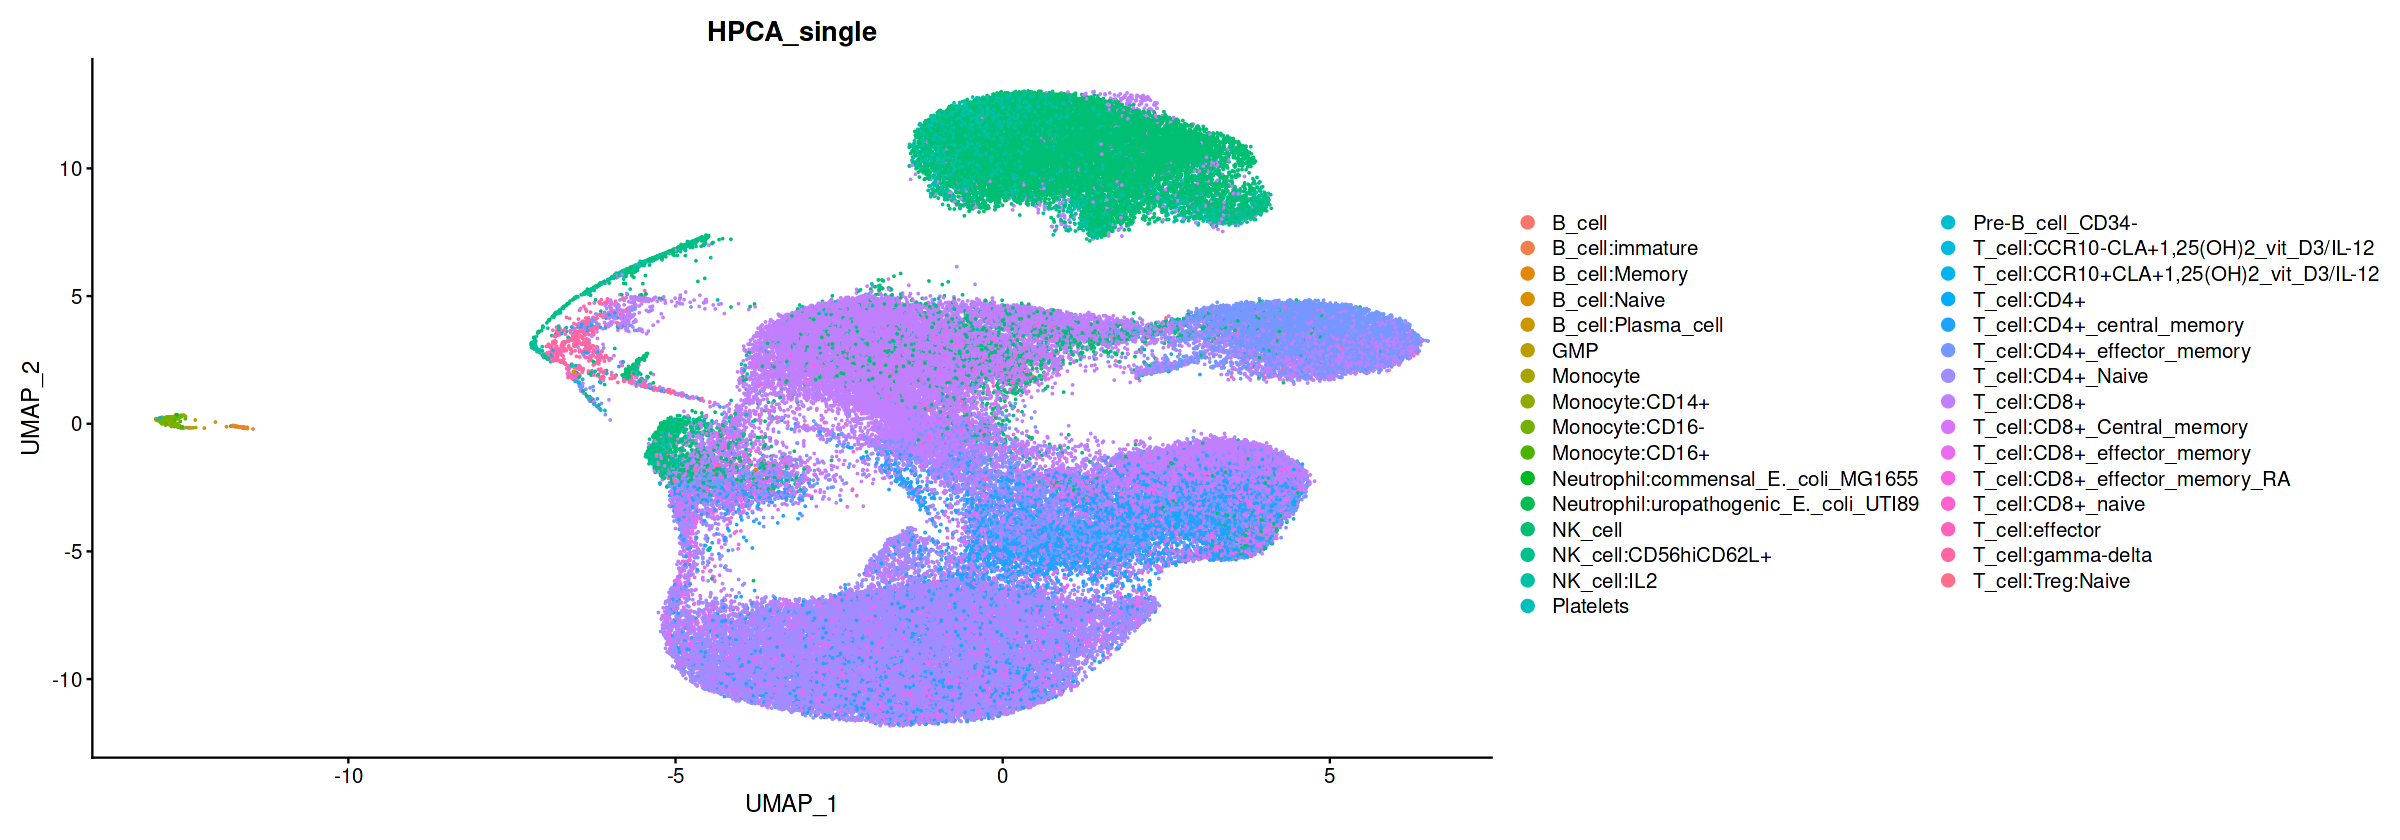

In [19]:
options(repr.plot.width = 20, repr.plot.height = 7)

DimPlot(new_dia_cd8, raster = F, group.by = "HPCA_single", label = F)

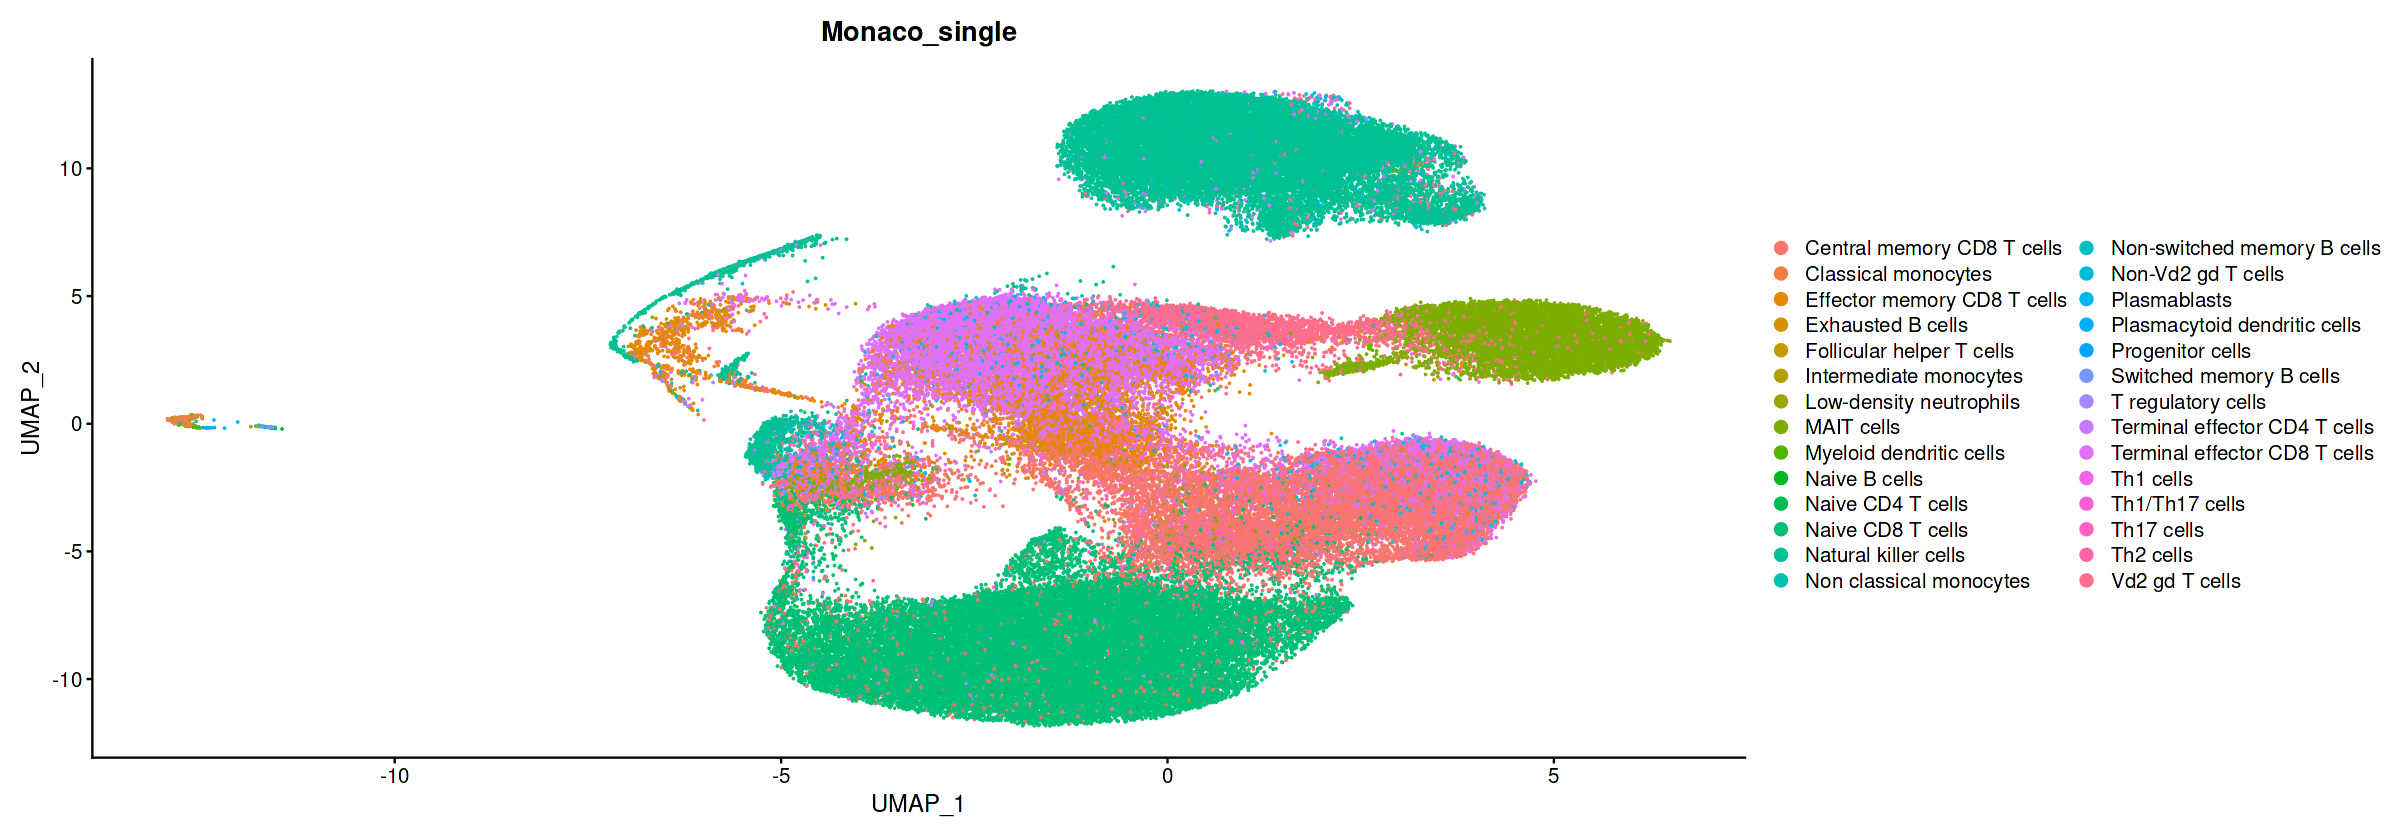

In [20]:
DimPlot(new_dia_cd8, raster = F, group.by = "Monaco_single", label = F)

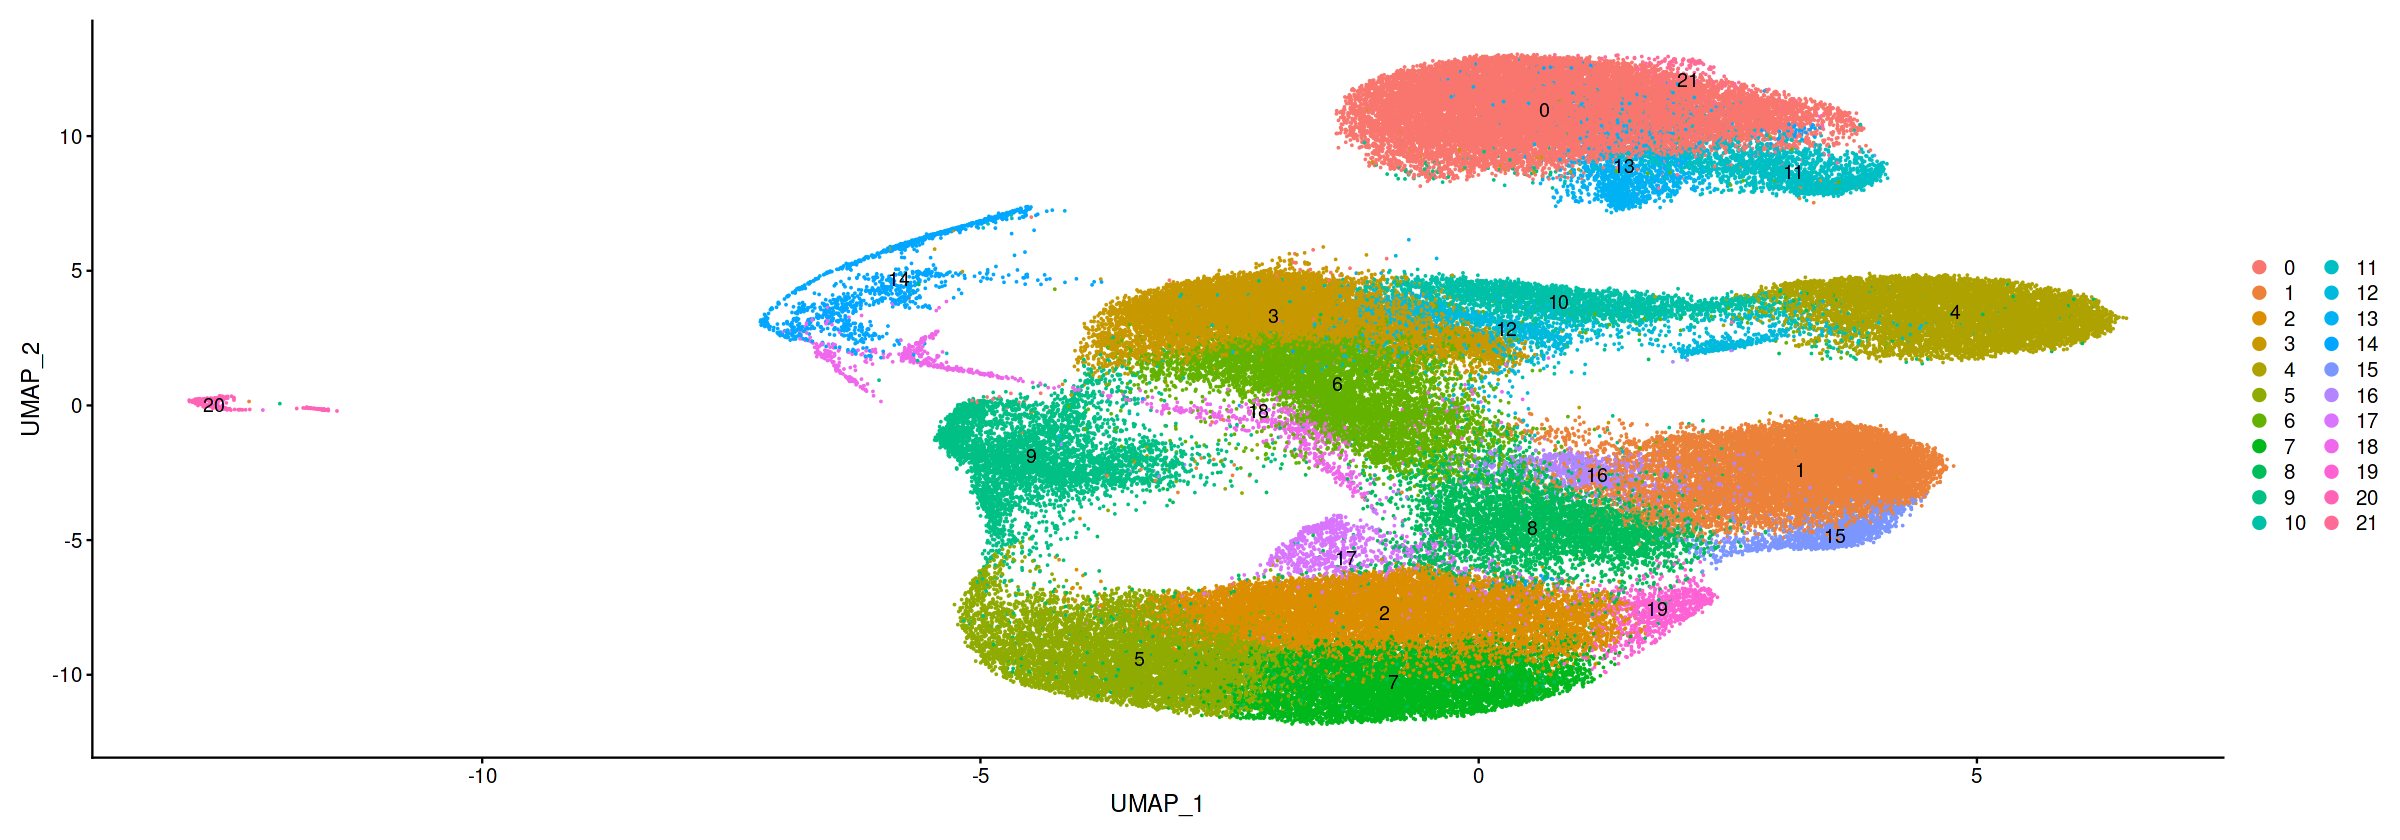

In [21]:
DimPlot(new_dia_cd8, label = T, raster = F)

### Remove dead and contaminating cells

In [22]:
cutoff_nFeature_RNA <- 500
cutoff_percent_mt <- 10
cluster_exclude  <- c(9,20)

Warning message in geom_hline(yintercept = cutoff_percent_mt, geom = "line", width = 0.5, :
“Ignoring unknown parameters: `geom` and `width`”
Warning message in geom_hline(yintercept = cutoff_nFeature_RNA, geom = "line", width = 0.5, :
“Ignoring unknown parameters: `geom` and `width`”


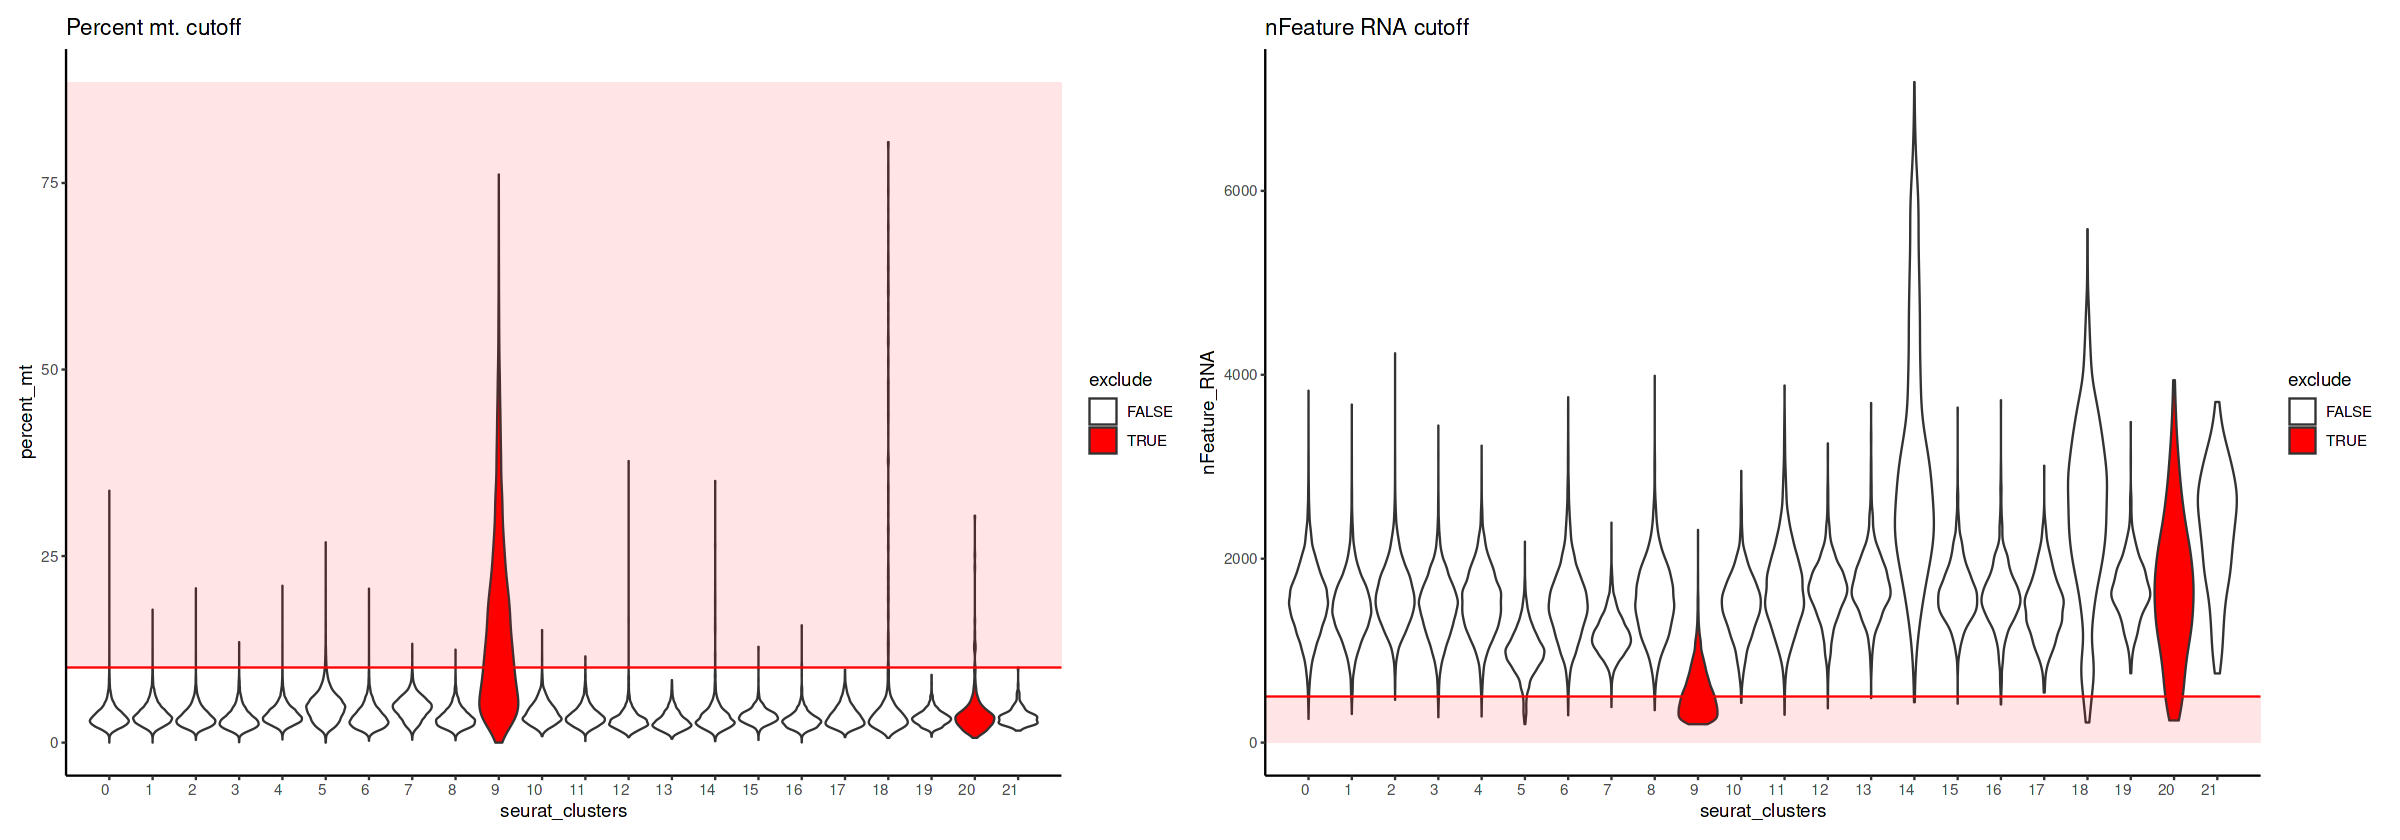

In [23]:
p1 <- ggplot(data.frame(nCount_RNA = new_dia_cd8$nCount_RNA,
                  nFeature_RNA = new_dia_cd8$nFeature_RNA,
                  percent_mt = new_dia_cd8$percent.mt,
                  seurat_clusters = new_dia_cd8$seurat_clusters,
                  exclude = ifelse(new_dia_cd8$seurat_clusters %in% cluster_exclude, TRUE, FALSE)), 
       aes(x = seurat_clusters, y = percent_mt)) +
  geom_violin(scale = "width", aes(fill = exclude)) + 
  geom_hline(yintercept = cutoff_percent_mt,
               geom = "line", 
               width = 0.5,
               colour = "red") + 
  ggtitle("Percent mt. cutoff") + 
  theme_classic() +
  scale_fill_manual(values = c("white","red")) +
  theme(panel.background = element_blank(), 
        axis.text.x = element_text(angle = 0, hjust = 1)) +
  annotate(geom = "rect", xmin = min(as.numeric(new_dia_cd8$seurat_clusters))-1, 
           xmax = max(as.numeric(new_dia_cd8$seurat_clusters))+1, 
           ymin=cutoff_percent_mt,ymax=1.1*(max(new_dia_cd8$percent.mt)), fill = "red", alpha = 0.1)

p2 <- ggplot(data.frame(nCount_RNA = new_dia_cd8$nCount_RNA,
                  nFeature_RNA = new_dia_cd8$nFeature_RNA,
                  percent_mt = new_dia_cd8$percent.mt,
                  seurat_clusters = new_dia_cd8$seurat_clusters,
                        exclude = ifelse(new_dia_cd8$seurat_clusters %in% cluster_exclude, TRUE, FALSE)), 
       aes(x = seurat_clusters, y = nFeature_RNA)) +
  geom_violin(scale = "width", aes(fill = exclude)) + 
  geom_hline(yintercept = cutoff_nFeature_RNA,
               geom = "line", 
               width = 0.5,
               colour = "red") + 
  ggtitle("nFeature RNA cutoff") + 
  theme_classic() +
  scale_fill_manual(values = c("white","red")) +
  theme(panel.background = element_blank(), 
        axis.text.x = element_text(angle = 0, hjust = 1)) +
  annotate(geom = "rect", xmin = min(as.numeric(new_dia_cd8$seurat_clusters))-1, 
           xmax = max(as.numeric(new_dia_cd8$seurat_clusters))+1, 
           ymin=0, ymax=cutoff_nFeature_RNA, fill = "red", alpha = 0.1)



p1 + p2

In [24]:
new_dia_cd8  <- subset(new_dia_cd8, 
                      percent.mt < cutoff_percent_mt &
                      nFeature_RNA > cutoff_nFeature_RNA & 
                       seurat_clusters %in% c(0:8,10:19,21))

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ref.umap_ to refumap_”


In [25]:
new_dia_cd8 <- NormalizeData(new_dia_cd8, verbose = FALSE)
new_dia_cd8 <- ScaleData(new_dia_cd8, verbose = FALSE)
new_dia_cd8 <- FindVariableFeatures(new_dia_cd8, nfeatures = 800, verbose = FALSE)
new_dia_cd8 <- RunPCA(new_dia_cd8, npcs = 12, verbose = FALSE)
new_dia_cd8 <- RunUMAP(new_dia_cd8, reduction = "pca", dims = 1:12)
new_dia_cd8 <- FindNeighbors(new_dia_cd8, dims = 1:12)
new_dia_cd8 <- FindClusters(new_dia_cd8, resolution = 1)

12:00:27 UMAP embedding parameters a = 0.9922 b = 1.112

12:00:27 Read 105591 rows and found 12 numeric columns

12:00:27 Using Annoy for neighbor search, n_neighbors = 30

12:00:27 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:00:42 Writing NN index file to temp file /tmp/RtmpM7YS7v/file48bc0156dceee

12:00:42 Searching Annoy index using 1 thread, search_k = 3000

12:01:44 Annoy recall = 100%

12:01:46 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

12:01:54 Initializing from normalized Laplacian + noise (using irlba)

12:02:08 Commencing optimization for 200 epochs, with 4465554 positive edges

12:03:27 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 105591
Number of edges: 2716315

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8498
Number of communities: 20
Elapsed time: 87 seconds


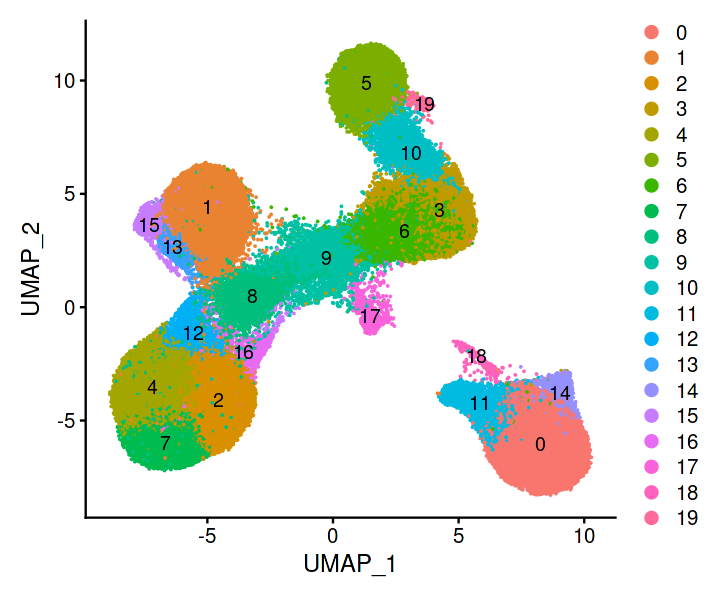

In [26]:
options(repr.plot.width = 6, repr.plot.height = 5)
DimPlot(new_dia_cd8, label = T, raster = F)

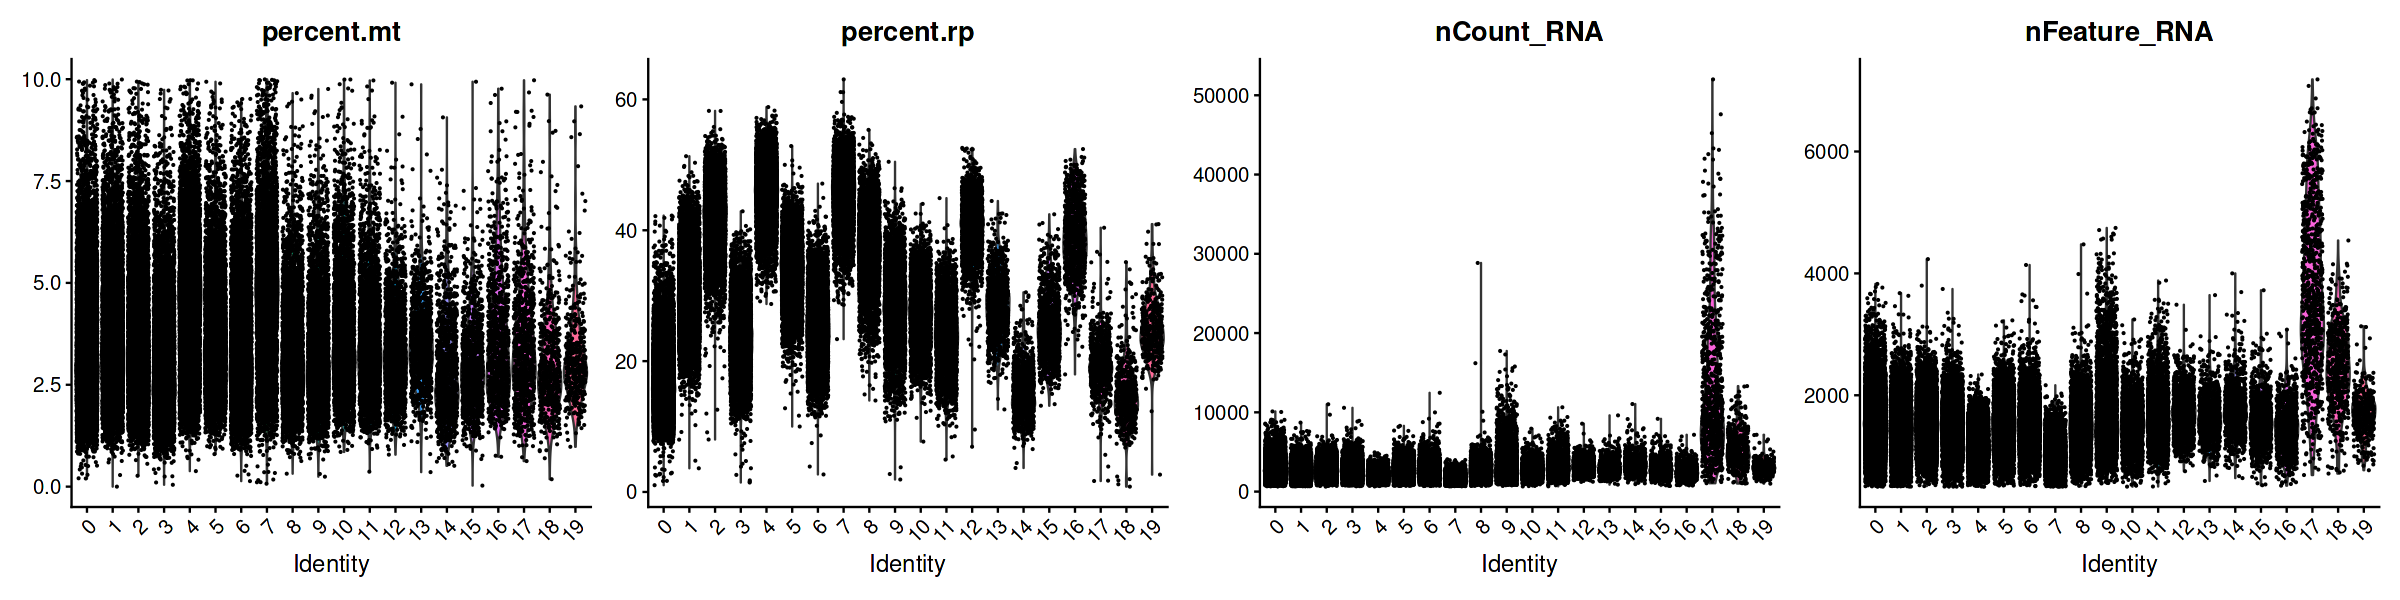

In [27]:
options(repr.plot.width = 20)
VlnPlot(new_dia_cd8, features = c("percent.mt", "percent.rp", "nCount_RNA", "nFeature_RNA"), ncol = 4, raster = F)

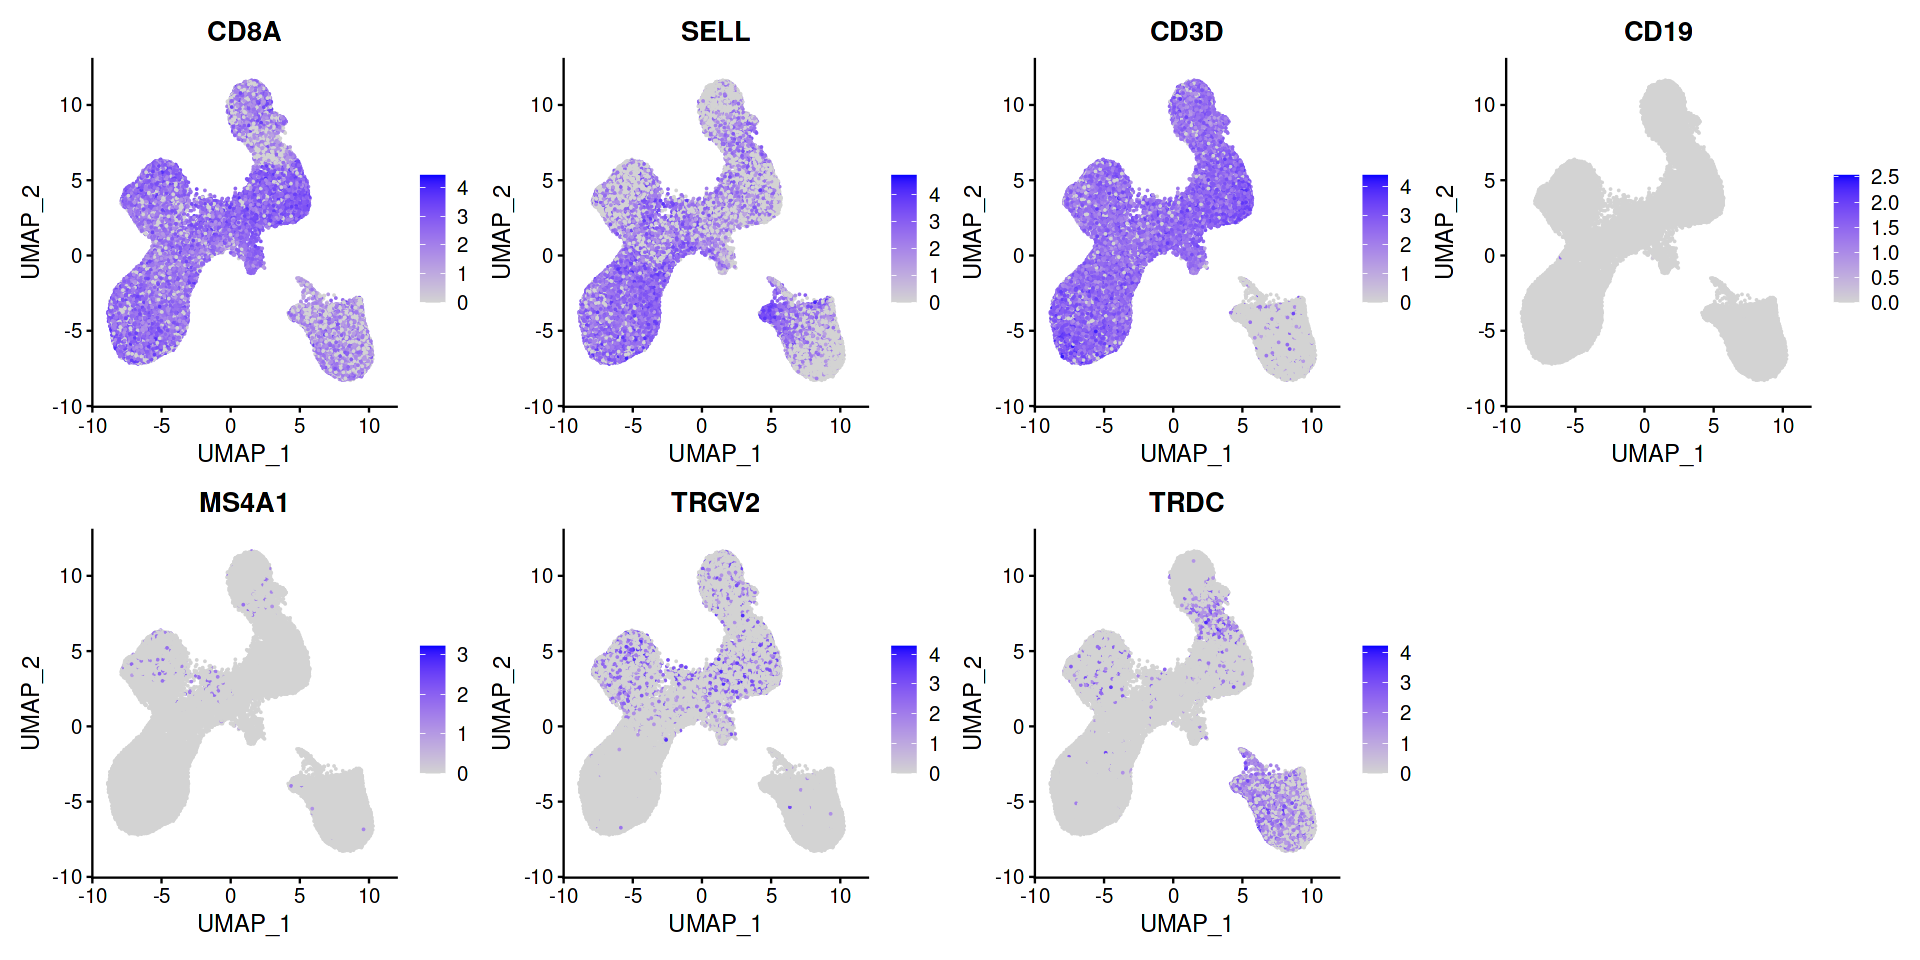

In [28]:
options(repr.plot.width = 16, repr.plot.height = 8)

FeaturePlot(new_dia_cd8, features = c("CD8A", "SELL", "CD3D", "CD19", "MS4A1", "TRGV2", "TRDC"), ncol = 4, raster = F)

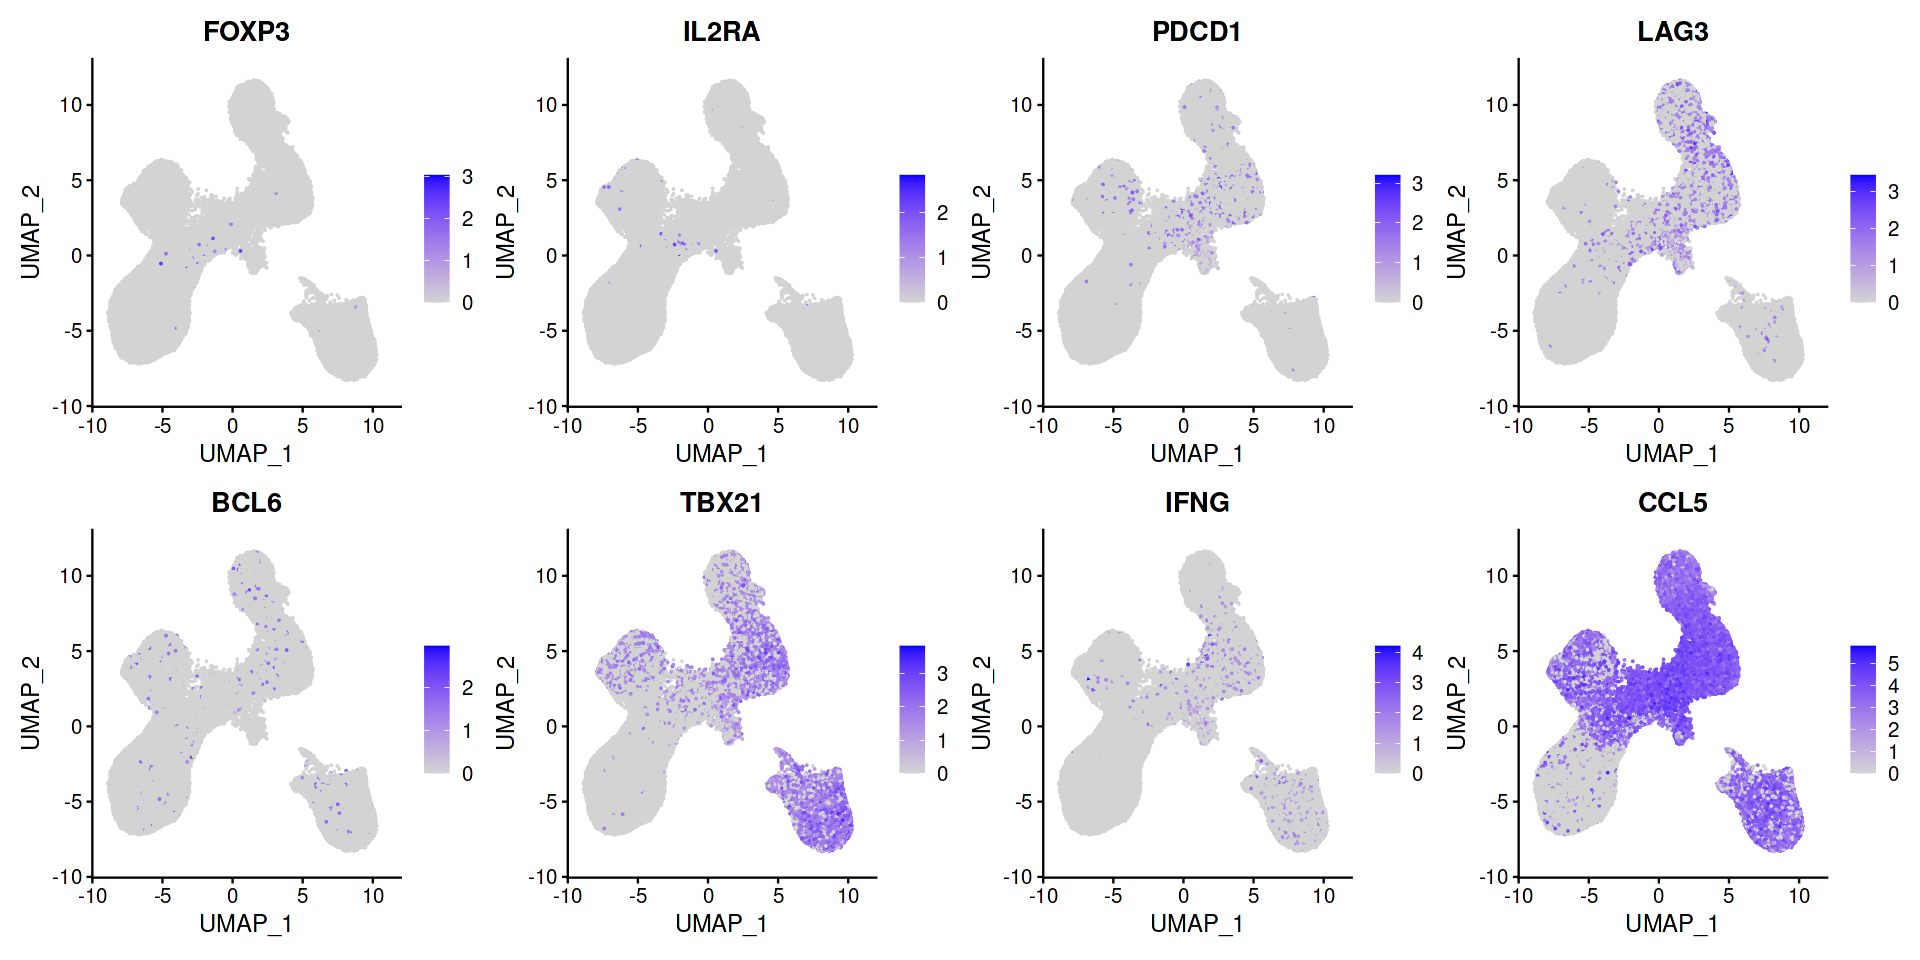

In [29]:
options(repr.plot.width = 16, repr.plot.height = 8)

FeaturePlot(new_dia_cd8, features = c("FOXP3", "IL2RA", "PDCD1", "LAG3", "BCL6", "TBX21", "IFNG", "CCL5"), ncol = 4, raster = F)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 105591
Number of edges: 2716315

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8892
Number of communities: 16
Elapsed time: 76 seconds


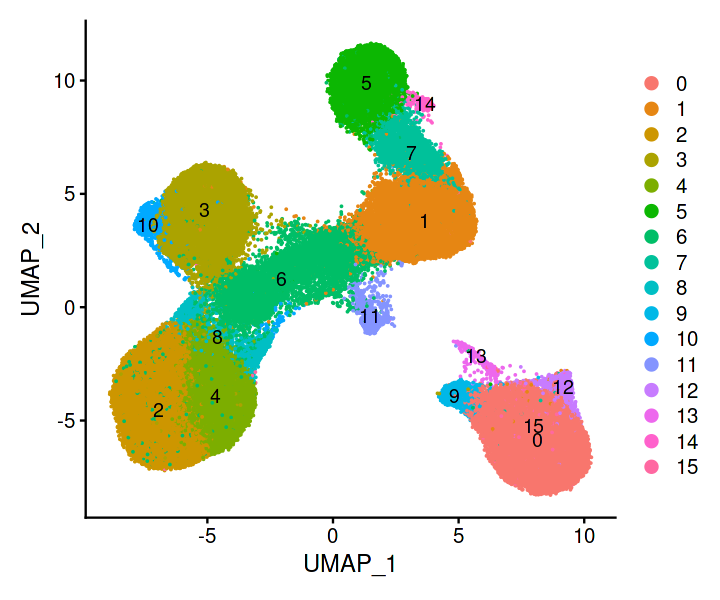

In [30]:
new_dia_cd8 <- FindClusters(new_dia_cd8, resolution = 0.6)

options(repr.plot.width = 6, repr.plot.height = 5)
DimPlot(new_dia_cd8, label = T, raster = F)

### PCA on samples

In [31]:
new_dia_cd8@meta.data  %>% colnames

[1] "orig.ident"                  "nCount_RNA"                 
 [3] "nFeature_RNA"                "percent.mt"                 
 [5] "percent.rp"                  "nCount_Antibodies"          
 [7] "nFeature_Antibodies"         "hashtags"                   
 [9] "Experiment_ID"               "Date_prepared"              
[11] "Prepared_by"                 "Sample_ID"                  
[13] "Well"                        "Hashtag"                    
[15] "Hashtag_sequence"            "Hashtag_cat_n"              
[17] "Hashtag_dilution"            "Project.code"               
[19] "Well_CT_ID"                  "Condition"                  
[21] "Species"                     "Age"                        
[23] "Age_group"                   "Sex"                        
[25] "Library_code"                "Patient_ID"                 
[27] "is_cell"                     "chain"                      
[29] "contig_id"                   "high_confidence"            
[31] "productive"                  "length"                     
[33] "reads"                       "umis"                       
[35] "vdj_source"                  "count_TRA"                  
[37] "count_TRB"                   "count_Multi"                
[39] "cdr3_A1"                     "cdr3_A1_nt"                 
[41] "cdr3_A2"                     "cdr3_A2_nt"                 
[43] "cdr3_B"                      "cdr3_B_nt"                  
[45] "cdr3_Multi"                  "cdr3_Multi_nt"              
[47] "v_gene_A1"                   "j_gene_A1"                  
[49] "v_gene_A2"                   "j_gene_A2"                  
[51] "v_gene_B"                    "d_gene_B"                   
[53] "j_gene_B"                    "v_gene_Multi"               
[55] "d_gene_Multi"                "j_gene_Multi"               
[57] "clonotypes"                  "has.VDJ"                    
[59] "has.complete.VDJ"            "nCount_PTPRC"               
[61] "nFeature_PTPRC"              "RNA_snn_res.0.5"            
[63] "seurat_clusters"             "clonotype.repeated"         
[65] "RNA_snn_res.0.8"             "RNA_snn_res.1"              
[67] "barcode"                     "Monaco_single"              
[69] "HPCA_single"                 "Wherry_main"                
[71] "nCount_refAssay"             "nFeature_refAssay"          
[73] "predicted.celltype.l1.score" "predicted.celltype.l1"      
[75] "predicted.celltype.l2.score" "predicted.celltype.l2"      
[77] "predicted.celltype.l3.score" "predicted.celltype.l3"      
[79] "mapping.score"               "refAssay_snn_res.1"         
[81] "refAssay_snn_res.0.6"

In [32]:
new_dia_cd8$Condition  %>% table

.
   Ctrl T0    Ctrl T1     Dia T0     Dia T1 Pre-Dia T0 
     20170       4457      45689      31645       3630 

In [33]:
new_dia_cd8@meta.data  <- new_dia_cd8@meta.data  %>% separate(Condition, into = c("Disease", "Time"), remove = F, sep = " ")

In [34]:
new_dia_cd8$Sample_char  <- paste(new_dia_cd8$Patient_ID, 
                                  new_dia_cd8$Disease,
                                  new_dia_cd8$Time,
                                  new_dia_cd8$Age_group,
                                  new_dia_cd8$Sex,
                                  new_dia_cd8$Experiment_ID)

In [35]:
cd8_samples  <- AverageExpression(new_dia_cd8, group.by = "Sample_char", return.seurat = T)

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from prediction.score.celltype.l1_ to predictionscorecelltypel1_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from prediction.score.celltype.l2_ to predictionscorecelltypel2_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from prediction.score.celltype.l3_ to predictionscorecelltypel3_”
Centering and scaling data matrix



In [36]:
cd8_samples  <- FindVariableFeatures(cd8_samples)

In [37]:
cd8_samples  <- RunPCA(cd8_samples)

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  ABHD17A, TGFB1, CAPNS1, PIP4K2A, AKT1, PREX1, KIAA2013, CD81, GNB1, GNAI2 
	   MAPK1, TRAPPC10, MAP2K2, ARL8A, FMNL1, EFHD2, STK39, ZNRF2, UTRN, TAF10 
	   ARHGAP26, PTP4A2, IQGAP1, GSK3A, CCDC92, CLPTM1L, QKI, RUNX3, BTBD6, BCL7C 
Negative:  RGS10, EIF3E, BTF3, NPM1, ST13, LSM5, ALKBH7, EIF3H, ANP32B, UQCRB 
	   PCBP2, OCIAD2, EEF1A1, C1QBP, SARAF, FKBP1A, PEBP1, LDLRAP1, IMPDH2, CCNI 
	   APEX1, LRRN3, ATP6V0E2, PLEKHB1, IFNGR2, NDFIP1, EIF2D, PRKAR1B, CLNS1A, TIMM9 
PC_ 2 
Positive:  SNRPD3, AC010422.8, CSNK2B, RNASEK, KLRK1, AC091959.1, DYNLRB1, STXBP2, NAA10, UBE2V1 
	   AC005833.1, MATR3.1, IL2RG, SARNP, AC129492.3, PTPRCAP, RAB5C, TRAPPC5, DHPS, AL358472.6 
	   ANKHD1, SLC35A1, AL365205.1, NOL12, ARL6IP1, CHMP4A, FKBP2, EEF1E1, VPS33A, PPAN-P2RY11 
Negative:  AMMECR1L, WASH6P, MTRNR2L12, R3HDM2, USF2, AC007

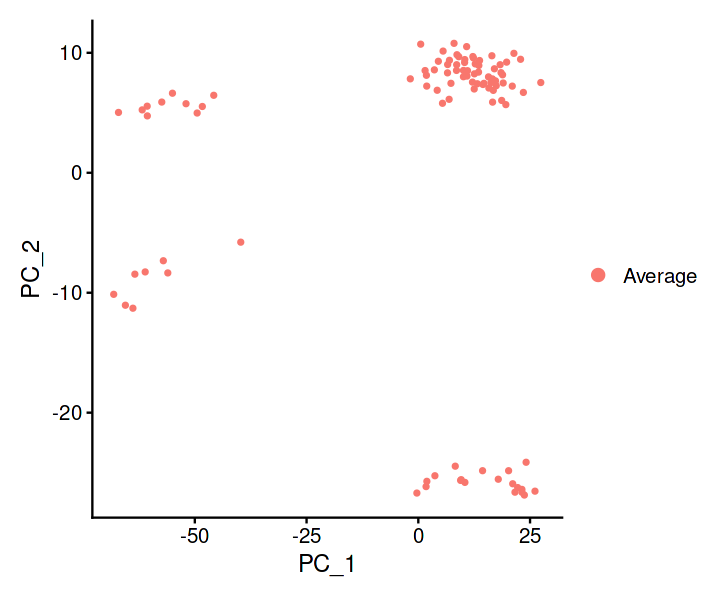

In [38]:
DimPlot(cd8_samples)

In [39]:
cd8_samples$Sample_char  <- colnames(cd8_samples)

In [40]:
cd8_samples$Sample_char  %>% table

.
    101 Dia T0 1 M Exp18     101 Dia T1 1 M Exp18     102 Dia T0 1 M Exp18 
                       1                        1                        1 
    102 Dia T1 1 M Exp18     103 Dia T0 2 M Exp18     103 Dia T1 2 M Exp18 
                       1                        1                        1 
    104 Dia T0 3 M Exp08     104 Dia T0 3 M Exp18     104 Dia T1 3 M Exp18 
                       1                        1                        1 
    105 Dia T0 1 M Exp08     105 Dia T0 1 M Exp18     105 Dia T1 1 M Exp18 
                       1                        1                        1 
    106 Dia T0 1 F Exp08     106 Dia T0 1 F Exp18     106 Dia T1 1 F Exp18 
                       1                        1                        1 
    107 Dia T0 1 M Exp11     107 Dia T0 1 M Exp18     107 Dia T1 1 M Exp18 
                       1                        1                        1 
    108 Dia T0 2 F Exp08     108 Dia T0 2 F Exp18     108 Dia T1 2 F Exp18 
          

In [41]:
cd8_samples@meta.data  <- cd8_samples@meta.data  %>% separate(Sample_char, 
                                                              into = c("Patient_ID",
                                                                      "Disease",
                                                                      "Time",
                                                                      "Age_group",
                                                                      "Sex",
                                                                      "Exp"), 
                                                             sep = " ",
                                                             remove = F)

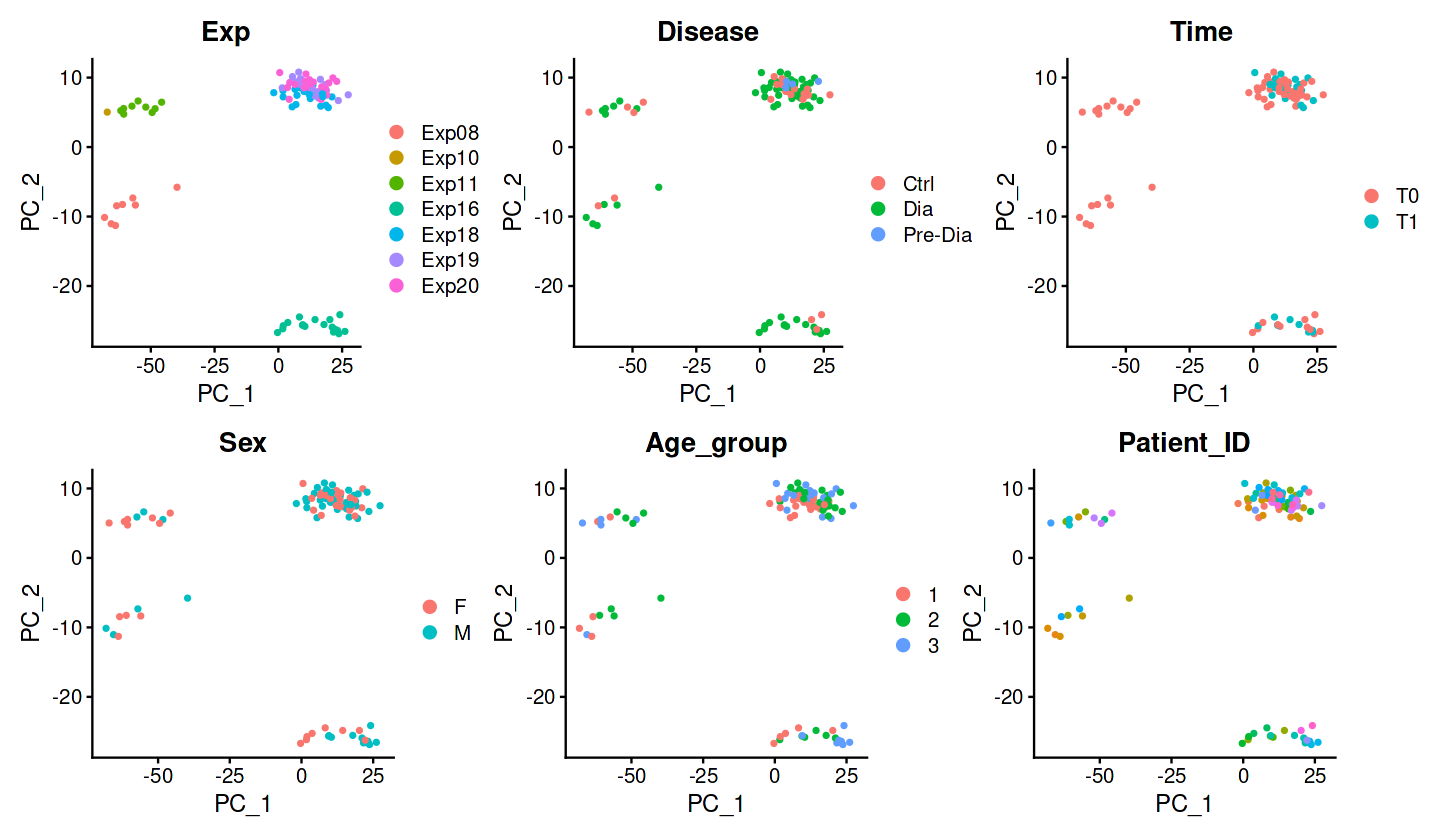

In [42]:
options(repr.plot.width = 12, repr.plot.height = 7)
(DimPlot(cd8_samples, group.by = "Exp") + DimPlot(cd8_samples, group.by = "Disease") + DimPlot(cd8_samples, group.by = "Time")) / (DimPlot(cd8_samples, group.by = "Sex") + DimPlot(cd8_samples, group.by = "Age_group") + (DimPlot(cd8_samples, group.by = "Patient_ID") + NoLegend()))

## STACAS Integration over Experiment

In [43]:
new_dia_experiment  <- SplitObject(new_dia_cd8, split.by = "Experiment_ID")

In [44]:
new_dia_experiment

$Exp08
An object of class Seurat 
30413 features across 7046 samples within 7 assays 
Active assay: refAssay (15152 features, 800 variable features)
 6 other assays present: RNA, Antibodies, PTPRC, prediction.score.celltype.l1, prediction.score.celltype.l2, prediction.score.celltype.l3
 4 dimensional reductions calculated: pca, umap, integrated_dr, ref.umap

$Exp10
An object of class Seurat 
30413 features across 650 samples within 7 assays 
Active assay: refAssay (15152 features, 800 variable features)
 6 other assays present: RNA, Antibodies, PTPRC, prediction.score.celltype.l1, prediction.score.celltype.l2, prediction.score.celltype.l3
 4 dimensional reductions calculated: pca, umap, integrated_dr, ref.umap

$Exp11
An object of class Seurat 
30413 features across 9615 samples within 7 assays 
Active assay: refAssay (15152 features, 800 variable features)
 6 other assays present: RNA, Antibodies, PTPRC, prediction.score.celltype.l1, prediction.score.celltype.l2, prediction.score.cell

In [ ]:
# normalize and identify variable features for each dataset independently
merged.list <- lapply(X = new_dia_experiment, FUN = function(x) {
    DefaultAssay(x)  <- "RNA"
    x$barcode  <- colnames(x)
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 800)
})

library(STACAS)

new_dia_experiment <- Run.STACAS(merged.list, dims = 1:12)
new_dia_experiment <- RunUMAP(new_dia_experiment, dims = 1:12) 

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.0 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.6 GiB”
Preparing PCA embeddings for objects...

Building integration tree with base dataset: 6



In [ ]:
# Visualize
DimPlot(new_dia_experiment, group.by = c("Experiment_ID"), raster=F)

### PCA on samples

In [ ]:
cd8_samples2  <- AverageExpression(new_dia_experiment, group.by = "Sample_char", return.seurat = T)

In [ ]:
cd8_samples2  <- FindVariableFeatures(cd8_samples2)

In [ ]:
cd8_samples2  <- RunPCA(cd8_samples2)

In [ ]:
DimPlot(cd8_samples2)

In [ ]:
cd8_samples2$Sample_char  <- colnames(cd8_samples2)

In [ ]:
cd8_samples2@meta.data  <- cd8_samples2@meta.data  %>% separate(Sample_char, 
                                                              into = c("Patient_ID",
                                                                      "Disease",
                                                                      "Time",
                                                                      "Age_group",
                                                                      "Sex",
                                                                      "Exp"), 
                                                             sep = " ",
                                                             remove = F)

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 7)
(DimPlot(cd8_samples2, group.by = "Exp") + DimPlot(cd8_samples2, group.by = "Disease") + DimPlot(cd8_samples2, group.by = "Time")) / 
(DimPlot(cd8_samples2, group.by = "Sex") + DimPlot(cd8_samples2, group.by = "Age_group") + (DimPlot(cd8_samples2, group.by = "Patient_ID") + NoLegend()))

# Add metadata

In [ ]:
md_dia  <- read_xlsx("data/dia_metadata.xlsx")

In [ ]:
md_dia

In [ ]:
md_seurat  <- new_dia_experiment@meta.data

In [ ]:
md_seurat$Patient_Time  <- paste(md_seurat$Patient_ID, md_seurat$Time)

In [ ]:
md_joined  <- left_join(md_seurat, md_dia)

In [ ]:
new_dia_experiment@meta.data  <- md_joined
rownames(new_dia_experiment@meta.data)  <- colnames(new_dia_experiment)

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 5)

DimPlot(new_dia_experiment, group.by = "matched_dataset_manual", raster = T)

In [ ]:
DimPlot(new_dia_experiment, group.by = "matched_dataset_propensity", raster = T)

In [ ]:
saveRDS(new_dia_experiment, "data/processed/cd8_full.rds")

# Analysis CD8 Level 1

In [ ]:
new_dia_cd8 <- FindNeighbors(new_dia_cd8, dims = 1:12)

In [ ]:
new_dia_cd8 <- FindClusters(new_dia_cd8, resolution = 0.6)

In [ ]:
DimPlot(new_dia_cd8, label = T, raster = F)

In [ ]:
new_dia_cd8@meta.data  <- new_dia_cd8@meta.data  %>% 
mutate(annotations_l1 = recode_factor(seurat_clusters, 
                                     "0" = "NK cells",
                                     "9" = "NK cells",
                                     "11" = "NK cells",
                                     "13" = "NK cells",
                                     "15" = "NK cells",
                                     "1" = "CD8 T cells",
                                     "2" = "CD8 T cells",
                                     "3" = "CD8 T cells",
                                     "5" = "CD8 T cells",
                                     "4" = "CD8 T cells",
                                     "6" = "Unconventional T cells",
                                     "7" = "Unconventional T cells",
                                     "8" = "CD8 T cells",
                                     "10" = "CD8 T cells",
                                     "12" = "CD8 T cells",
                                     "14" = "Unconventional T cells"
                                     ))

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 8)

DimPlot(new_dia_cd8, group.by = "annotations_l1", raster = F)

In [ ]:
saveRDS(new_dia_cd8, "data/processed/cd8_full.rds")

# Analysis CD8 Level 2

## Analysis CD8 Level 2: Conventional CD8+ T cells

In [ ]:
merged.list  <- SplitObject(subset(new_dia_cd8, annotations_l1 == "CD8 T cells"), split.by = "Experiment_ID")

In [ ]:
merged.list <- lapply(X = merged.list, FUN = function(x) {
    DefaultAssay(x)  <- "RNA"
    x$barcode  <- colnames(x)
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 800)
})

In [ ]:
new_dia_experiment2 <- Run.STACAS(merged.list, dims = 1:12)
new_dia_experiment2 <- RunUMAP(new_dia_experiment2, dims = 1:12) 

In [ ]:
cd8_subcluster  <- new_dia_experiment2

In [ ]:
cd8_subcluster <- FindNeighbors(cd8_subcluster, reduction = "pca", dims = 1:12)

In [ ]:
cd8_subcluster <- FindClusters(cd8_subcluster, resolution = 0.6)

In [ ]:
DimPlot(cd8_subcluster)

In [ ]:
saveRDS(cd8_subcluster, "data/processed/cd8_subcluster.rds")

In [ ]:
cd8_subcluster  <- readRDS("data/processed/cd8_subcluster.rds")

In [ ]:
plan("multisession")

In [ ]:
mrk  <- FindAllMarkers(cd8_subcluster, logfc.threshold = log(1.5))

In [ ]:
write.csv(mrk, "markers_cd8_full.csv")

### Cluster tree

In [ ]:
DimPlot(cd8_subcluster, label = T)

In [ ]:
cd8_subcluster <- BuildClusterTree(
  cd8_subcluster,
  dims = 1:12,
  reorder = FALSE,
  reorder.numeric = FALSE
)

In [ ]:
tree <- cd8_subcluster@tools$BuildClusterTree
tree$tip.label <- paste0("Cluster ", tree$tip.label)

In [ ]:
p <- ggtree::ggtree(tree, aes(x, y)) +
  scale_y_reverse() +
  ggtree::geom_tree() +
  ggtree::theme_tree() +
  ggtree::geom_tiplab(offset = 1) +
  ggtree::geom_tippoint(color = (scales::hue_pal() (15)), shape = 16, size = 5) +
  coord_cartesian(clip = 'off') +
  theme(plot.margin = unit(c(0,2.5,0,0), 'cm'))

#ggsave('plots/cluster_tree.png', p, height = 4, width = 6)

In [ ]:
options(repr.plot.width=3.5, repr.plot.height=3)
p

## Analysis CD8 Level 2: NK cells

In [ ]:
merged.list  <- SplitObject(subset(new_dia_cd8, annotations_l1 == "NK cells"), split.by = "Experiment_ID")

In [ ]:
merged.list <- lapply(X = merged.list, FUN = function(x) {
    DefaultAssay(x)  <- "RNA"
    x$barcode  <- colnames(x)
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 800)
})

In [ ]:
new_dia_experiment2 <- Run.STACAS(merged.list, dims = 1:12)
new_dia_experiment2 <- RunUMAP(new_dia_experiment2, dims = 1:12) 

In [ ]:
nk_subcluster  <- new_dia_experiment2

In [ ]:
nk_subcluster <- FindNeighbors(nk_subcluster, reduction = "pca", dims = 1:12)

In [ ]:
nk_subcluster <- FindClusters(nk_subcluster, resolution = 0.6)

In [ ]:
DimPlot(nk_subcluster)

In [ ]:
saveRDS(nk_subcluster, "data/processed/nk_subcluster.rds")

## Analysis CD8 Level 2: Unconventional cells

# Analysis CD8 Level 3

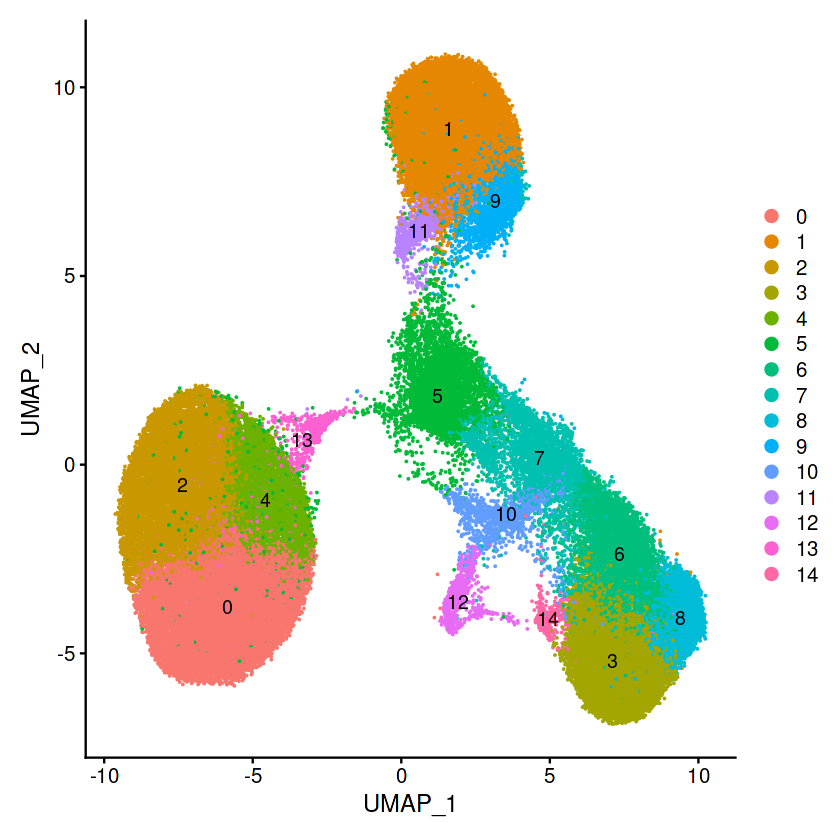

In [18]:
DimPlot(cd8_subcluster, label = T)

## Analysis CD8 Level 3: Teff

In [19]:
teff <- subset(cd8_subcluster, seurat_clusters %in% c(3,5,6,7,8,10,12,14))

In [20]:
teff

An object of class Seurat 
16142 features across 27197 samples within 4 assays 
Active assay: integrated (976 features, 976 variable features)
 3 other assays present: RNA, Antibodies, PTPRC
 2 dimensional reductions calculated: pca, umap

In [21]:
teff_dia_experiment  <- SplitObject(teff, split.by = "Experiment_ID")

In [22]:
teff_dia_experiment

$Exp08
An object of class Seurat 
16142 features across 1053 samples within 4 assays 
Active assay: integrated (976 features, 976 variable features)
 3 other assays present: RNA, Antibodies, PTPRC
 2 dimensional reductions calculated: pca, umap

$Exp10
An object of class Seurat 
16142 features across 80 samples within 4 assays 
Active assay: integrated (976 features, 976 variable features)
 3 other assays present: RNA, Antibodies, PTPRC
 2 dimensional reductions calculated: pca, umap

$Exp11
An object of class Seurat 
16142 features across 1276 samples within 4 assays 
Active assay: integrated (976 features, 976 variable features)
 3 other assays present: RNA, Antibodies, PTPRC
 2 dimensional reductions calculated: pca, umap

$Exp16
An object of class Seurat 
16142 features across 3979 samples within 4 assays 
Active assay: integrated (976 features, 976 variable features)
 3 other assays present: RNA, Antibodies, PTPRC
 2 dimensional reductions calculated: pca, umap

$Exp18
An object o

In [23]:
plan("sequential")

In [24]:
# normalize and identify variable features for each dataset independently
merged.list <- lapply(X = teff_dia_experiment, FUN = function(x) {
    DefaultAssay(x)  <- "RNA"
    x$barcode  <- colnames(x)
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 500)
})

library(STACAS)

teff_dia_experiment <- Run.STACAS(merged.list, dims = 1:10)
teff_dia_experiment <- RunUMAP(teff_dia_experiment, dims = 1:10) 

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -1.9218”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.49582”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  2.8365e-16”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.090619”
Excluding 1 datasets with < 100 cells

You may alter this behavior by setting the min.sample.size parameter

Preparing PCA embeddings for objects...

Building integration tree with base dataset: 5

Merging dataset 3 into 6

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 6 3 into 5

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Int

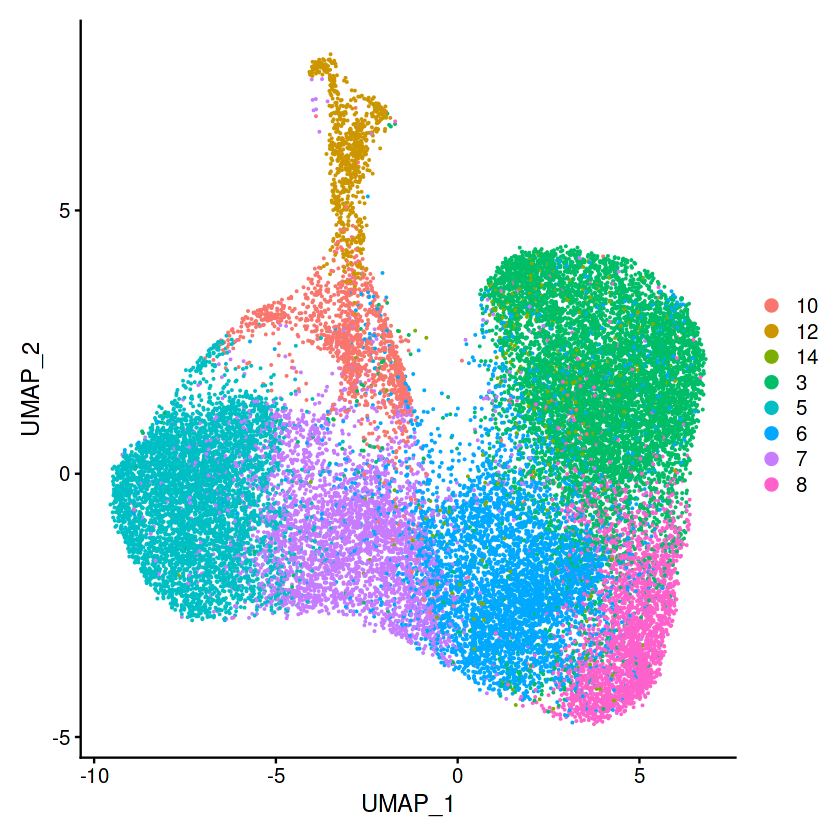

In [25]:
# Visualize

DimPlot(teff_dia_experiment)

In [26]:
teff_dia_experiment  <- FindNeighbors(teff_dia_experiment)
teff_dia_experiment  <- FindClusters(teff_dia_experiment, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 27117
Number of edges: 769714

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8490
Number of communities: 8
Elapsed time: 7 seconds


In [32]:
saveRDS(teff_dia_experiment, "data/processed/cd8_subcluster_teff.rds")